# Inteligencja obliczeniowa - Projekt 1
**Autor:** *Paweł Olszewski*

# Wstęp

Poniższa praca opisuje moje implementacje algorytmów inspirowanych biologicznie rozwiązujących nonogramy czyli japońskie łamigłówki polegające na tworzeniu obrazków po przez zamalowywanie odpowiednich pixeli zgodnie ze wzorami zawartymi na krawędziach planszy. Zamalowane pixele tworzą bloki których kolejność, długość i kolor muszą zgadzać się z szablonem podanym na początku rzędu bądź kolumny. W przyadku jednokolorowych bloków musi być zachowana między nimi przerwa co najmniej jednego pixela.

W dalszej części pracy zostały opisane algorytmy:
- Dwa algorytmy genetyczne rozwiązujące problem dla czarno białych nonogramów
- Dwa algorytmy typu rój cząstek rozwiązujące problem dla czarno białych nonogramów
- Dwa algorytmy genetyczne rozwiązujące problem dla kolorowych nonogramów

# 1. Pierwsza wersja algortmu genetycznego

Pierwsza wersja algorytmu działa na prostej zasadzie, traktuje każdy pixel obrazka jako osobny gen **(num_genes = height\*width)** który może być albo zamalowany albo pusty **(genes_pace = [0, 1])**. Po losowym przydzieleniu wartości dla każdego pixela funkcja **fitness_func** ocenia rozwiązanie, porównując wzory w jakie układają się zamalowane bloki do wzorów które opisują obrazek, dla każdego rzędu i kolumny obrazka. Korzysta ona z funkcji **gradeFunc** która po otrzymaniu listy pixeli *(postaci [1, 0, 0, 0, 1, 1])* i wzoru *(postaci [1,2])*:
- tworz z pierwszego parametru drugi wzór
- porównuje ilość zamalowanych pixeli w obu wzorach *(jeden pixel różnicy jeden punkt ujemny)*
- porównuje każy element obu wzorów *(jeśli n'ty element wyenerowanego wzoru nie zgadza się z n'tym elementem orginalnego wzoru to odejmuje różnicę długości tych elementów od ogólnego wyniku, a jeśli wzory nie są równej długości to dodatkowo odejmuję długości nadmiarowych bloków)*
- zwaraca ilość ujemnych punktów

Algorytm kończy się gdy rozwiąże nonogram lub gdy przez dwieście generacji najlepszy wynik się nie zmieni. Po zakończeniu program wypisze ilość generacji jaką mu zajęło odnajdywanie wyniku, dopasowanie *(Fitness)* odnalezionego wyniku oraz wyświetli wykres jak zmieniało się dopasowanie najlepszego rozwiązania oraz wyświetli wygenerowany obrazek. W przypadku nie odnalezienia poprawnego rozwiązania funkcja dodatkowo wypisze w konsoli wszystkie rzędy i kolumny z których składa się obrazek, wraz z ich punktacją.

Ta wersja algorytmu potrafi bezbłędnie rozwiązać nonogram wielkości 10x10 w bardzo krótkim czasie, aczkolwiek nie zawsze jej się udaje.

>Zauważyłem że wszystkie stwożone przeze mnie algorytmy działją najlepiej gdy wartość **mutation_percent_genes** jest możliwie najmniejsza, lecz co ważne nie *zerowa*, więc napisałem funkcję **getPercentageOfMutations(num_genes)** która dobiera ten parametr w taki sposób aby tylko jeden gen był wybierany do mutowania. Ta funkcja jest użyta we wszystkich funkcjach opisanych w tej pracy

Generations: 278 Fitness: -4
Mistakes in paterns:
rows
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 0
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 0
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0.] 0
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0.] 0
[0. 1. 1. 1. 1. 1. 0. 0. 0. 0.] 0
[0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 0
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.] 0
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0.] 0
[1. 0. 1. 0. 1. 0. 0. 1. 0. 1.] 0
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0.] -2
columns
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0] 0
[0, 0, 0, 0, 1, 0, 1, 1, 0, 1] 0
[0, 0, 0, 1, 1, 0, 1, 1, 1, 0] 0
[0, 0, 1, 1, 1, 0, 1, 1, 0, 1] 0
[0, 1, 1, 1, 1, 0, 1, 1, 1, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1] 0
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1] -2
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0] 0
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1] 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 0
░░░░░░░░░░██░░░░░░░░
░░░░░░░░████░░░░░░░░
░░░░░░██████░░░░░░░░
░░░░████████░░░░░░░░
░░██████████░░░░░░░░
░░░░░░░░░░██░░████░░
████████████████░░░░
░░████████████░░░░░░
██░░██░░██░░░░██░░██
░░██░░██░░████░░██░░


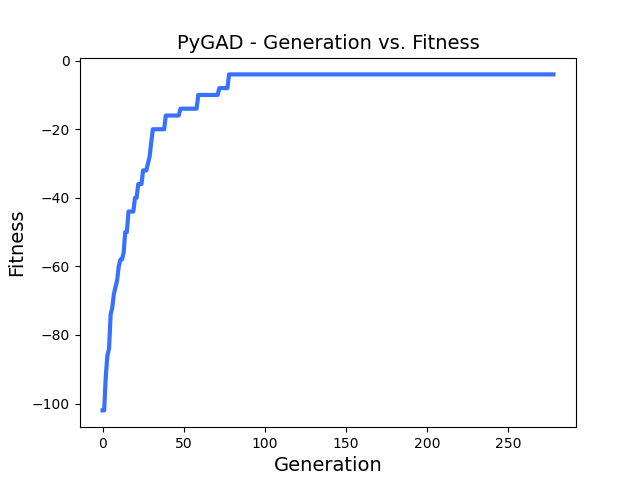

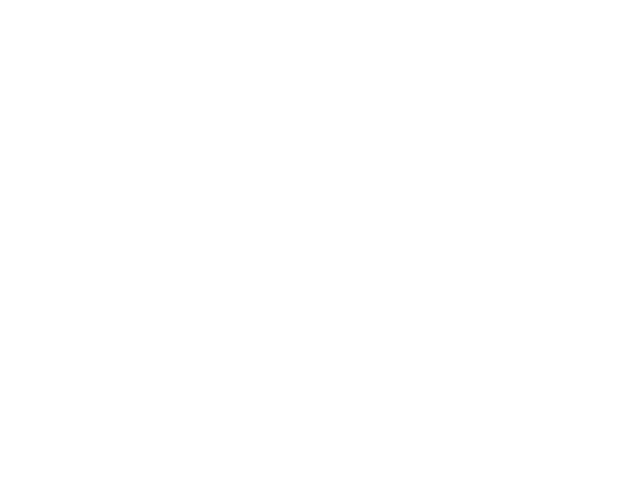

In [1]:
import piplite
await piplite.install('pygad')
import pygad
import numpy as np
import matplotlib.pyplot as plt

# statek
verticalM10 = [[1,1],[1,2,1],[2,3],[3,2,1],[4,3],[8,1],[3],[2,1],[1,1],[1]]
horizontalM10 = [[1],[2],[3],[4],[5],[1,2],[8],[6],[1,1,1,1,1],[1,1,1,1,1]]

def getPercentageOfMutations(num_genes):
    return 100/num_genes

def runAlgorythmV1(verticalPattern, horizontalPattern):
    height = len(verticalPattern)
    width = len(horizontalPattern)

    def createImg(genes, height, width):
        img = np.zeros((height, width))
        index = 0
        for i in range(height):
            for j in range(width):
                img[i][j] = abs(genes[index]-1)
                index += 1
        
        return img

    def gradeFunc(solution, pattern):
        solutionPattern = [0]
        for i in solution:
            if i == 0:
                solutionPattern.append(0)
            else:
                if solutionPattern[-1] != 0:
                    solutionPattern[-1] = solutionPattern[-1] + 1
                else:
                    solutionPattern.append(1)
        filteredRowPatern = list(filter(lambda n: n != 0 , solutionPattern))

        grade = -abs(sum(pattern) - sum(filteredRowPatern))

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i] - filteredRowPatern[i])
            else:
                grade -= pattern[i]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)]

        return grade

    def fitness_func(solution, solution_idx):
        rowsGrade = 0
        for i in range(height):
            row = solution[i * width: i * width + width]
            grade = gradeFunc(row, horizontalPattern[i])
            rowsGrade += grade

        columnsGrade = 0
        for i in range(width):
            column = []
            for j in range(height):
                column.append(solution[j * height + i])
            grade = gradeFunc(column, verticalPattern[i])
            columnsGrade += grade

        fitness = rowsGrade + columnsGrade
        return fitness

    gene_space = [0, 1]
    num_genes = height * width
    fitness_function = fitness_func
    sol_per_pop = 100

    num_parents_mating = 42
    num_generations = 5000
    keep_parents = 6
    parent_selection_type = "sss"
    crossover_type = "single_point"
    mutation_type = "random"
    mutation_percent_genes = getPercentageOfMutations(num_genes)
    stop_criteria = ["reach_0", "saturate_200"]

    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=stop_criteria)
    ga_instance.run()
    print("Generations:", ga_instance.generations_completed, "Fitness:", ga_instance.best_solution()[1])

    genes = ga_instance.best_solution()[0]

    if ga_instance.best_solution()[1] != 0:
        print("Mistakes in paterns:")

        print("rows")
        for i in range(height):
                row = genes[i * width: i * width + width]
                grade = gradeFunc(row, horizontalPattern[i])
                print(row, grade)

        print("columns")
        for i in range(width):
            column = []
            for j in range(height):
                column.append(int(genes[j * height + i]))
            grade = gradeFunc(column, verticalPattern[i])
            print(column, grade)

    img = createImg(genes, height, width)

    # wyświetlanie wygenerowanego obrazka w konsoli
    for i in range(height):
            for j in range(width):
                if img[i][j] == 0:
                    print("██", end="")
                else:
                    print("░░", end="")
            print("")

    plt.imshow(img, cmap="gray")
    ga_instance.plot_fitness()
    plt.show()
    return ga_instance

runAlgorythmV1(verticalM10, horizontalM10)